To run this notebook, click "Runtime" -> "Run All" on the top menu bar.

# K-Means Clustering on Subscription Cancellation Dataset and Product Review Dataset

This notebook will output csvs of subscription cancellations and product reviews by cluster (closely related topics) to help By Humankind better identify what they can improve about their products.

# Setup



*   K-means clustering is an unsupervised machine learning algorithm that group similar data points together and identify common patterns in them. To do this, K-means finds a fixed number of clusters, k,  in a dataset where each cluster represents a collection of data points grouped together due to their similarities.

*   We will be performing K-means clustering on the subscription_cancellations.csv in this notebook in order to determine the common customer feedbacks within this dataset.

*   We will also be performing it on the product_reviews dataset to identify more trends or patterns that could further support why certain products are getting cancelled.




To start, we first import the necessary libraries.


In [6]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

from google.colab import files

pip install -U yellowbrick

from yellowbrick.cluster import KElbowVisualizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Directions

The two below cells will each prompt you for a file upload. The first file upload should be in the format as the `subscription_cancellations.csv` file shared with our team. The second file upload should be in the same format as the `product_reviews.csv` file shared with our team.

There is also a table of contents on the left sidebar to help with navigation!

In [7]:
uploaded_sc = files.upload()

Saving subscription_cancellations.csv to subscription_cancellations.csv


In [8]:
uploaded_pr = files.upload()

Saving product_reviews.csv to product_reviews.csv


# Methodology, Helper Functions
We'll be separating the data into different dataframes based on product categories and then perform TFIDF vectorization on them. The purpose of TFIDF vectorizing is to transforms text into feature vectors that can be used as input to the estimator based on inverse document frequency. Inverse document frequency highlight words that are more interesting and downscales words that appear a lot. In this process, we are also filtering out English stopwords and punctuations that are often not important to the feature extraction. 

Next, we will be using the elbow plot to determine the number of k clusters to use in our K-means clustering. The elbow method computes an average distortion score for all clusters for each k and from there we can determine which k to use by observing where there is an elbow shape on our plot.

After determining the number of k clusters to use, we can proceed to perform K-means clustering on our dataframes and from here the different clusters for each product will be exported as a csv to Google Drive. Visual inspection on the common patterns in the review in each cluster can be done from here.

In [11]:
import io
df = pd.read_csv(io.BytesIO(uploaded_sc['subscription_cancellations.csv']))
prod_reviews = pd.read_csv(io.BytesIO(uploaded_pr['product_reviews.csv']))

In [12]:
# ok_critical only contains reviews that have the rating 'Ok' or 'Critical'
ok_critical = prod_reviews.query("RATING == 'Ok' or RATING == 'Critical'")

df_d = df[df.product_name == "Deodorant"].dropna()
df_m = df[df.product_name == "Mouthwash"].dropna()
df_s = df[df.product_name == "Shampoo"].dropna()
df_f = df[df.product_name == "Floss"].dropna()
df_c = df[df.product_name == "Conditioner"].dropna()
df_t = df[df.product_name == "Toothpaste"].dropna()

# TFIDF Vectorizer, takes in a dataframe and number of features (integer), returns a vector
def vectorizing(df, n_features):
  corpus = df.cancellation_reason_comments
  vectorizer = TfidfVectorizer(stop_words='english', max_features=n_features, lowercase = True)
  X = vectorizer.fit_transform(corpus)
  return X

# TFIDF Vectorizer, with different corpus, default max_features at 200, returns a vector
def vectorizing_corpus(df, corpus):
  vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=200)
  X = vectorizer.fit_transform(corpus)
  return X

# Plotting function for the elbow plot, takes in the vector
def elbow_plot(X):
  model = KMeans(n_clusters = 8, random_state = 0)
  visualizer = KElbowVisualizer(model, k=(2,12), timings=True)
  visualizer.fit(X.toarray())        
  visualizer.show() 

# Kmeans clustering, takes in a vector, dataframe, and k number of clusters (integer), returns a dataframe of the cluster
def kmeans(X, df, num_clusters):
  kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(X)
  df['kmeans_label'] = kmeans.labels_
  return df

# Export the clusters for each product as a csv to google drive
def export_clusters_csv(df, product, num_clusters):
  for i in np.arange(num_clusters):
    cluster_result = df[df.kmeans_label == i].cancellation_reason_comments.to_frame()
    csv_name = product + str(i) + ".csv"
    cluster_result.to_csv('drive/My Drive/'+ csv_name, index =False)

# Export the clusters for each product as a csv to google drive
def export_prod_review_clusters_csv(num_clusters):
  for i in np.arange(num_clusters):
    cluster_result = ok_critical[ok_critical.kmeans_label == i].REVIEW.to_frame()
    csv_name = "prod_review_cluster_" + str(i) + ".csv"
    cluster_result.to_csv('drive/My Drive/'+ csv_name, index =False)

# Display a bar chart of the number of product types for each type of rating. 
def bar_chart(rating): #rating args = 'Ok', 'Critical', 'Good', 'Great'
  df = prod_reviews[prod_reviews['RATING'] == rating]
  return df['PRODUCT'].value_counts().plot(kind='bar')

# Initializes stemming object, set stop_words to English, also add product names to list of stop_words
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))
for prod in ok_critical['PRODUCT'].unique():
  stop_words.add(prod.lower())

# Function to preprocess text. 
# Removes anything that isn't a word or space character, makes every word lowercase, and tokenizes every word (takes the stem of a word).
def preprocess_text(line):
  line = re.sub(r"[^\w\s]", "", line)
  line = line.lower()
  tokens = word_tokenize(line)
  new_line = []
  for token in tokens:
      if token not in stop_words:
        new_line.append(token + " ")
  final = "".join(new_line)
  return final[:len(final)]

# Subscription Cancellation Clustering

**First step**: Use the vectorizing method to get the vector for each product.

In [13]:
X_d = vectorizing(df_d, 200)
X_m = vectorizing(df_m, 200)
X_s = vectorizing(df_s, 200)
X_f = vectorizing(df_f, 200)
X_c = vectorizing(df_c, 200)
X_t = vectorizing(df_t, 200)

**Second step**: Plot the elbow curve to determine the number of clusters to use for each product. The k where the "elbow" occurs can be found through looking at the plot and at the legend "elbow at k = ...". In this case, we would get:

Deodorant: k = 6

Mouthwash: k = 7

Shampoo: k = 7

Floss: k = 7

Conditioner: k = 7

Toothpaste: k = 6

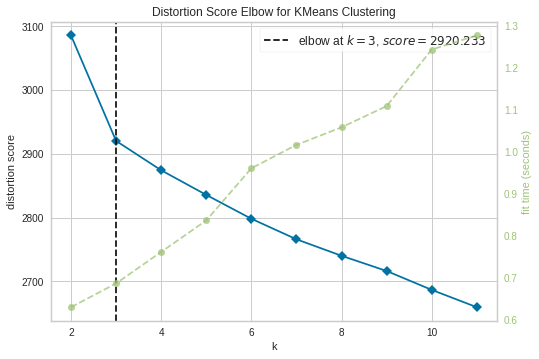

In [14]:
elbow_plot(X_d)


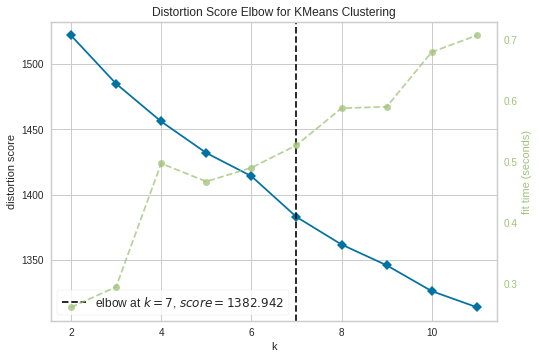

In [15]:
elbow_plot(X_m)

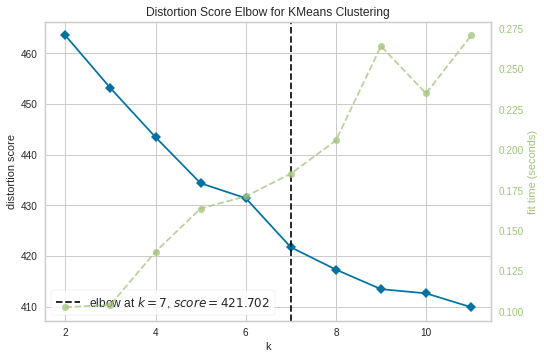

In [16]:
elbow_plot(X_f)

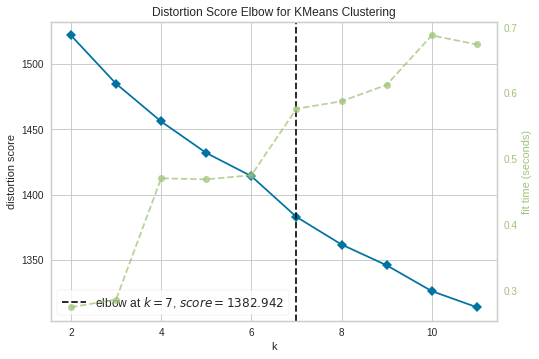

In [17]:
elbow_plot(X_m)

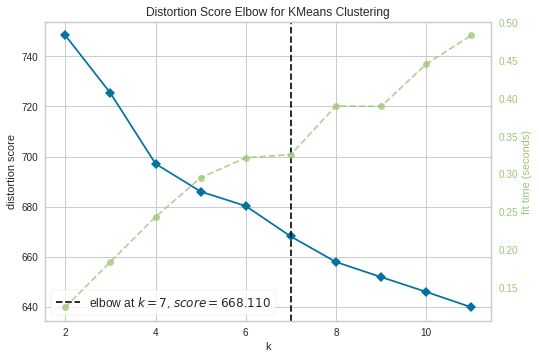

In [18]:
elbow_plot(X_s)

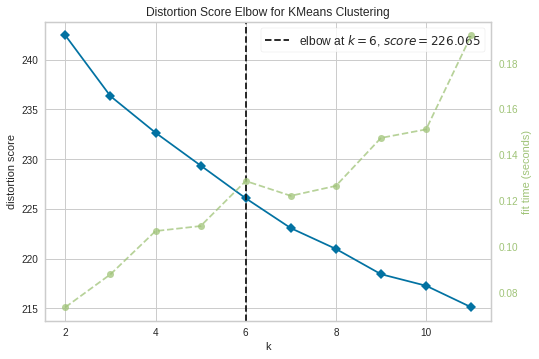

In [19]:
elbow_plot(X_t)

**Third Step**: Apply K-means clustering using the k number of clusters found from the previous step, inputing in the specific arguments to the function kmeans.

In [20]:
df_d = kmeans(X_d, df_d, 6)
df_m = kmeans(X_m, df_m, 7)
df_s = kmeans(X_s, df_s, 7)
df_f = kmeans(X_f, df_f, 7)
df_c = kmeans(X_c, df_c, 7)
df_t = kmeans(X_t, df_t, 6)

**Fourth Step**: Export the clusters as csv to Google Drive (To find the csv, go to My Drive => Recent). Further analysis on common patterns can be done through visual inspection of the csv.

In [21]:
export_clusters_csv(df_d, "Deodorant", 6)
export_clusters_csv(df_m, "Mouthwash", 7)
export_clusters_csv(df_s, "Shampoo", 7)
export_clusters_csv(df_f, "Floss", 7)
export_clusters_csv(df_c, "Conditioner", 7)
export_clusters_csv(df_t, "Toothpaste", 6)

## Analysis of Subscription Cancellation Clusters

Deodorant:
*   Cluster 0: Packaging is hard to use, difficult to open and messy. Had an allergic reaction, rash to it.
*   Cluster 1: Does not work well to combat smell, left stains on armpits/clothes. Does not glide on smoothly, very chalky.
* Cluster 2: Subscription is too frequent, has trouble connecting to account to adjust frequency of subscription, didn’t know they were signed up for a subscription, want to just order as they need it.
*  Cluster 3: Doesn’t work as a deodorant, gave them a rash.
*  Cluster 4: Prefer another brand. Doesn’t like the scent. Don’t go through much product. Bad reaction in armpits.
*  Cluster 5:Item cancelled for reason: 'stop_retrying' by CUSTOMER.


Mouthwash:
*   Cluster 0: Not strong enough. Didn’t like the taste, flavorless wanted it to be mintier. Tartaric acid can cause problems for teeth. Dentist advised against the product due to menthol. Double subscription.
*   Cluster 1: Item cancelled for reason: 'stop_retrying' by CUSTOMER
*   Cluster 2: Will order when needed.
*   Cluster 3: More minty flavor, needs to leave mouth feeling fresher.
*   Cluster 4: Tablet needs to dissolve faster and more efficiently.
*   Cluster 5: Didn’t clean mouth properly, no refreshing feeling.
*   Cluster 6: Need more intense mouthwash for dental needs, need fluoride. Not minty enough and not effective. 

Shampoo:
*   Cluster 0: Item cancelled for reason: 'stop_retrying' by CUSTOMER.
*   Cluster 1: Wash away the color of dyed hair, made hair too dry, and scalp itchy. Contains palm oil which is derived from an invasive process harmful to animals and the environment. 
*   Cluster 2: Don’t like the subscription, will order when needed, problems with shipping.
*   Cluster 3: Left hair feeling greasy and coarse, waxy film.
*   Cluster 4: Can’t afford the product.
*   Cluster 5: Hair felt greasy, coarse, and not clean after using product.
*   Cluster 6: OUT OF STOCK // NO RESTOCK ETA.

Floss:
* Cluster 0: Hard to unspool, floss frays, fibers get stuck in gums and cause irritation.
* Cluster 1: Not durable, breaks easily. Doesn’t spin and disperse easily.
* Cluster 2: Breaks and gets stuck between teeth.
* Cluster 3: Duplicate subscription, don’t use enough for refill.
* Cluster 4: Accidentally set up subscription, double subscription.
* Cluster 5: Not durable, breaks too easily.

Conditioner:
* Cluster 0: Item cancelled for reason: 'stop_retrying' by CUSTOMER, too expensive.
* Cluster 1: Didn’t help with tangle, made hair feel waxy and dry. Didn’t moisturize/hydrate enough. Difficult to apply.
* Cluster 2: Dried out hair, caused tangle.
* Cluster 3: Need the subscription less often.
* Cluster 4: Not nourishing, dried hair and scalp, not for curly hair.
* Cluster 5: Conditioner bar is hard to work with, crumbled, hard to spread. 
* Cluster 6: left hair waxy and greasy.

Toothpaste:
* Cluster 0: Double order, subscription coming in too early. Want fluoride-free option, tablets too small.
* Cluster 1: Not minty, didn’t clean enough, left stain.
* Cluster 2: Too expensive.
* Cluster 3: Too gritty, causing teeth sensitivity. Didn’t like dry toothpaste.
* Cluster 4: Didn’t like the fluoride, didn’t work to clean.
* Cluster 5: Didn’t like the chalky texture, want it to be mintier.


# Product Reviews Clustering

**Now onto analysis of product_reviews with a similar procedure above.**

This is a small visualization of each type of rating and the number of reviews that fall into that rating.

In [22]:
prod_reviews['RATING'].value_counts()

Great       673
Ok          278
Good        202
Critical    145
Name: RATING, dtype: int64

We can explore the number of each product types for each rating. 

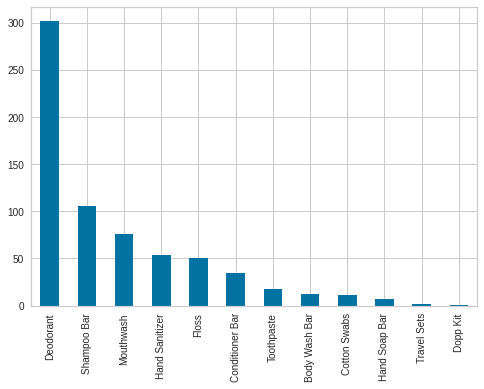

In [23]:
bar_chart('Great')

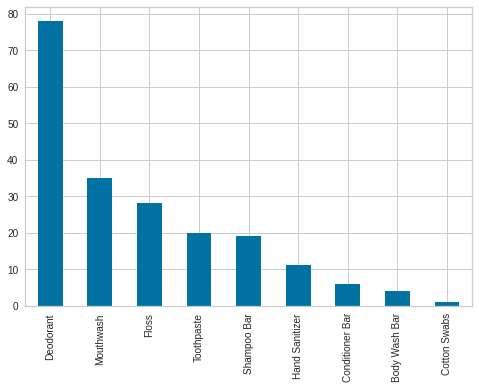

In [24]:
bar_chart('Good')

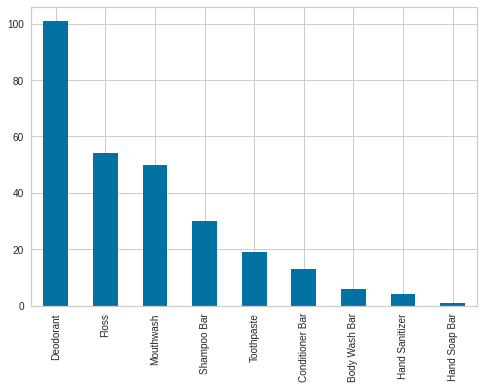

In [25]:
bar_chart('Ok')

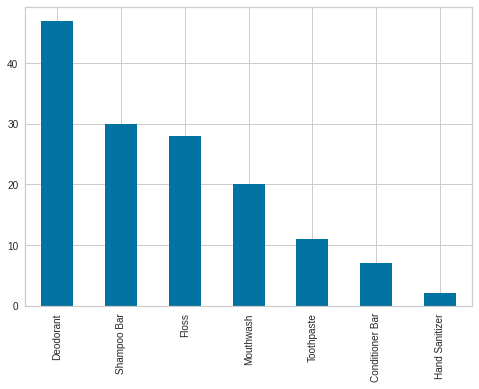

In [26]:
bar_chart('Critical')

**For this dataset, we will solely focus on the reviews that only have ratings 'Ok' or 'Critical.'**

In [27]:
ok_critical['PRODUCT'].value_counts()

Deodorant          148
Floss               82
Mouthwash           70
Shampoo Bar         60
Toothpaste          30
Conditioner Bar     20
Body Wash Bar        6
Hand Sanitizer       6
Hand Soap Bar        1
Name: PRODUCT, dtype: int64

Preprocess all of the reviews and remove rows that do not have a review. Create the K-Means clustering model. Now in the dataframe, each review has a label for the cluster it belongs to. We try 4 clusters at first, but using an elbow plot we see that 5 clusters is the optimal number.

In [28]:
ok_critical['REVIEW'] = ok_critical['REVIEW'].apply(preprocess_text)
ok_critical = ok_critical.dropna()
corpus = ok_critical.REVIEW
vectorizer = TfidfVectorizer(stop_words='english', max_features=200)
X = vectorizer.fit_transform(corpus)
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
ok_critical['kmeans_label'] = kmeans.labels_
ok_critical

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,PRODUCT,RATING,REVIEW,DATE,kmeans_label
769,Mouthwash,Ok,takes long dissolve pretty much tasteless even...,3/17/20,3
770,Deodorant,Ok,want say amazing brand mission less plastic wa...,3/26/20,2
771,Shampoo Bar,Ok,hair oily side product made feel heavy isnt gr...,3/24/20,1
772,Mouthwash,Ok,smell amazing got mixed bag flavors arent stro...,4/21/20,3
773,Deodorant,Ok,smells nice works recycled replacement instruc...,3/24/20,2
...,...,...,...,...,...
1283,Deodorant,Ok,want like leaves white plus get rid underarm h...,4/10/21,1
1284,Shampoo Bar,Critical,leaves gross sticky feeling hair like clean re...,4/10/21,1
1286,Shampoo Bar,Ok,leaves hair bit greasy,4/12/21,1
1288,Toothpaste,Critical,wanted love mildneutral much use mainstream to...,4/12/21,3


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['bar', 'body', 'conditioner', 'hand', 'sanitizer', 'shampoo', 'soap', 'wash'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


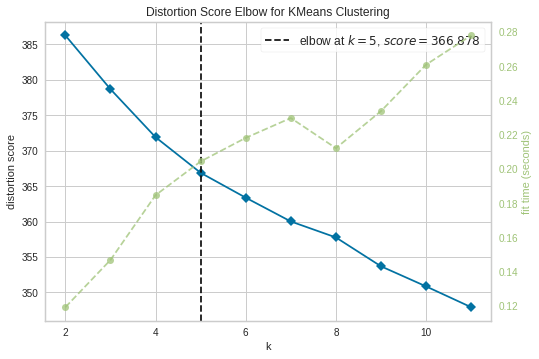

In [29]:
elbow_plot(vectorizing_corpus(ok_critical, ok_critical.REVIEW))

In [30]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)
ok_critical['kmeans_label'] = kmeans.labels_
ok_critical['kmeans_label'].value_counts()

0    179
1     84
2     74
3     46
4     40
Name: kmeans_label, dtype: int64

In [31]:
export_prod_review_clusters_csv(5)

## Analysis of Product Review Clusters

**Now you have csv files of all the clusters! Upon visually inspecting them you can notice that:**

* Mouthwash tablets -- great concept but doesn’t freshen breath, not enough minty flavor, tastes like baking soda

* Shampoo -- leaves hair feeling oily, dry, stiff, greasy, waxy & leaves residue
Not compatible with certain hair types?

* Floss -- again great idea but breaks easily and frays, hard to use between tight teeth

* Containers as a whole -- again great idea but many difficulties with container 